# Entraînement des Modèles SARIMA

Ce notebook effectue l'entraînement, l'évaluation et l'enregistrement des modèles SARIMA pour la prévision de la demande.
Nous utiliserons `train_sarimax.csv` pour l'entraînement et `test_sarimax.csv` pour le test.

Objectifs :
1.  Entraîner un modèle SARIMA par produit.
2.  Entraîner un modèle SARIMA global.
3.  Utiliser des variables exogènes (Prix, Promotion, etc.).
4.  Sauvegarder les modèles dans le dossier `trained_models`.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import itertools
import warnings
import os
import pickle

warnings.filterwarnings("ignore")

# Création du dossier pour les modèles s'il n'existe pas
os.makedirs('trained_models', exist_ok=True)

/home/raph/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Chargement et Prétraitement des Données

In [2]:
# Chargement des données
train_path = 'donnees_pretraitees/train_sarimax.csv'
test_path = 'donnees_pretraitees/test_sarimax.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Conversion de la colonne Date
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Tri par Date
df_train = df_train.sort_values(by=['Product ID', 'Date'])
df_test = df_test.sort_values(by=['Product ID', 'Date'])

print("Aperçu Train:")
print(df_train.head())
print("\nAperçu Test:")
print(df_test.head())

Aperçu Train:
  Product ID       Date  Units Sold      Price   Discount  Holiday/Promotion  \
0      P0001 2022-01-02        1353  52.911000  13.000000                  1   
1      P0001 2022-01-09        4606  59.785714  12.857143                  1   
2      P0001 2022-01-16        3557  46.740000  11.857143                  1   
3      P0001 2022-01-23        4920  53.180857  11.714286                  1   
4      P0001 2022-01-30        5003  58.546000  11.000000                  1   

   Competitor Pricing  
0           51.658000  
1           59.474857  
2           46.705714  
3           53.205143  
4           59.188857  

Aperçu Test:
  Product ID       Date  Units Sold      Price   Discount  Holiday/Promotion  \
0      P0001 2023-08-13        4521  51.735714  11.714286                  1   
1      P0001 2023-08-20        4225  46.377714  11.857143                  1   
2      P0001 2023-08-27        5256  50.934857  11.000000                  1   
3      P0001 2023-09-03    

## 2. Fonction de Grid Search pour SARIMA

Puisque `pmdarima` n'est pas disponible, nous implémentons une recherche manuelle des meilleurs hyperparamètres (Grid Search) basée sur le critère AIC.

In [3]:
def optimize_sarima(series, exog, p_range, d_range, q_range, P_range, D_range, Q_range, s):
    """
    Trouve les meilleurs paramètres SARIMA basés sur l'AIC.
    """
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, [s]))
    
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None
    
    print("Début du Grid Search...")
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    series,
                    exog=exog,
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = mod.fit(disp=False)
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = param
                    best_seasonal_order = param_seasonal
                    best_model = results
                    # print(f"Nouveau meilleur AIC: {best_aic} avec {param} x {param_seasonal}")
            except Exception as e:
                continue
                
    print(f"Meilleur modèle trouvé: SARIMAX{best_order}x{best_seasonal_order} - AIC:{best_aic}")
    return best_model, best_order, best_seasonal_order

## 3. Entraînement par Produit


=== Traitement Produit: P0001 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1318.6423148617719
Produit P0001 - RMSE: 1026.29, MAE: 686.91


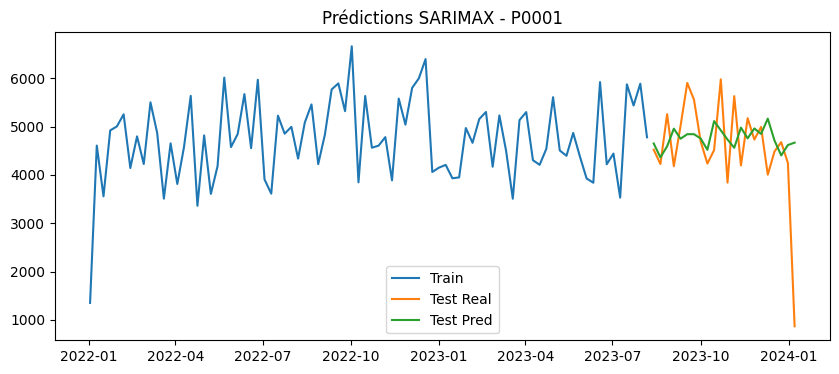


=== Traitement Produit: P0002 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1285.0774464725878
Produit P0002 - RMSE: 1105.31, MAE: 711.33


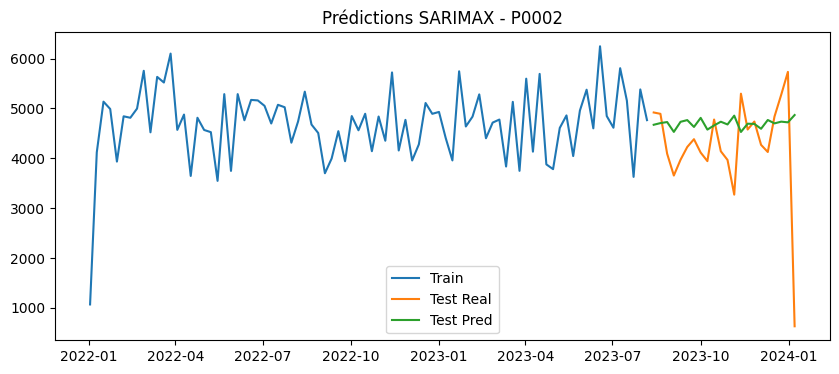


=== Traitement Produit: P0003 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1304.0170821786248
Produit P0003 - RMSE: 1050.38, MAE: 603.50


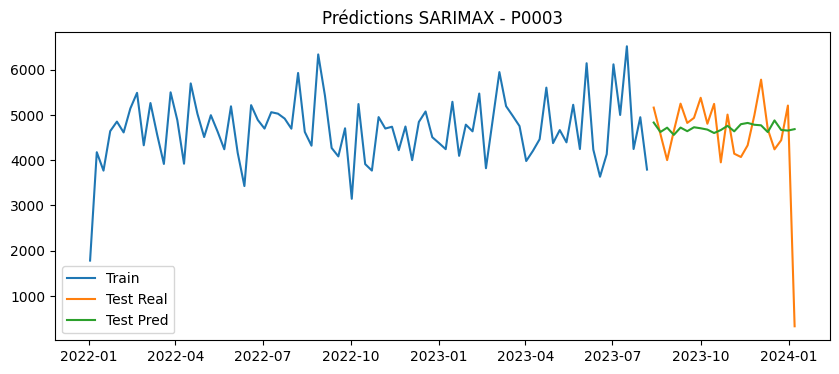


=== Traitement Produit: P0004 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1270.325687945475
Produit P0004 - RMSE: 1138.96, MAE: 798.86


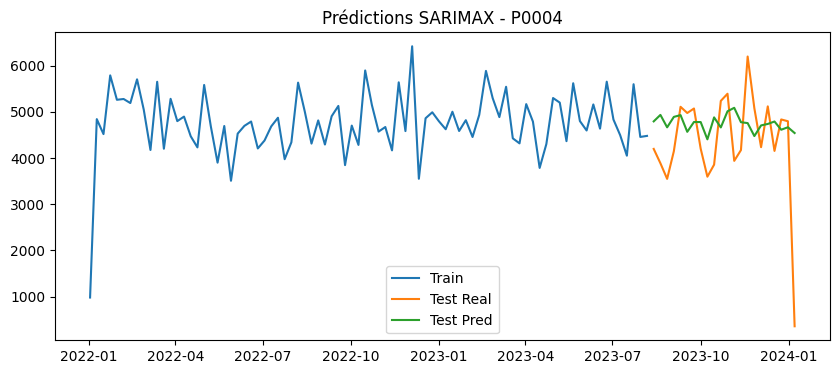


=== Traitement Produit: P0005 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1270.6593258475343
Produit P0005 - RMSE: 971.57, MAE: 611.46


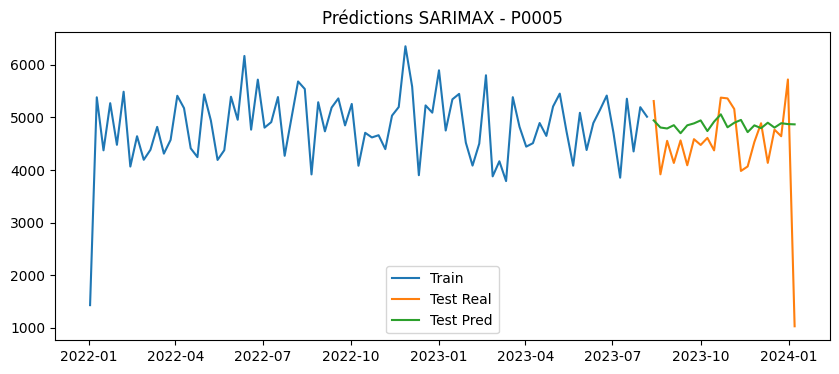


=== Traitement Produit: P0006 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1288.894882413927
Produit P0006 - RMSE: 1154.23, MAE: 751.45


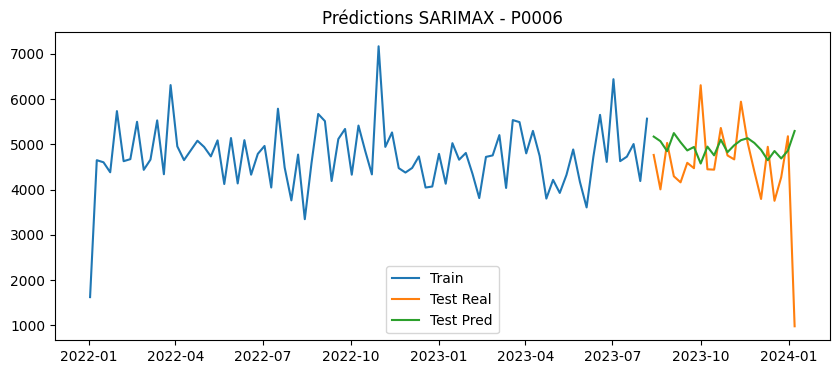


=== Traitement Produit: P0007 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1293.2742904181437
Produit P0007 - RMSE: 1082.62, MAE: 552.14


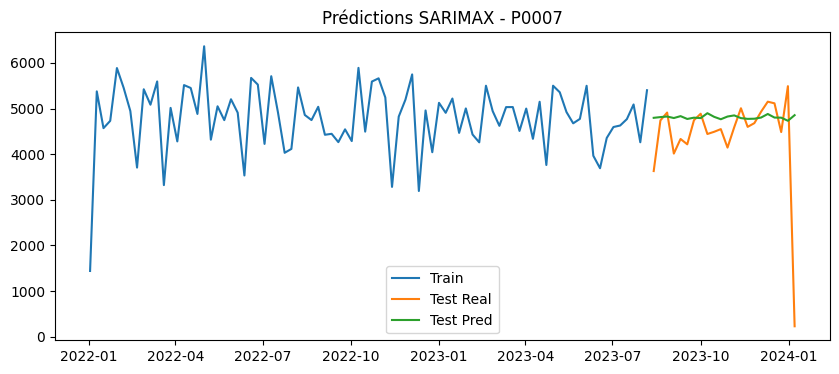


=== Traitement Produit: P0008 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1299.650008872242
Produit P0008 - RMSE: 1098.71, MAE: 725.45


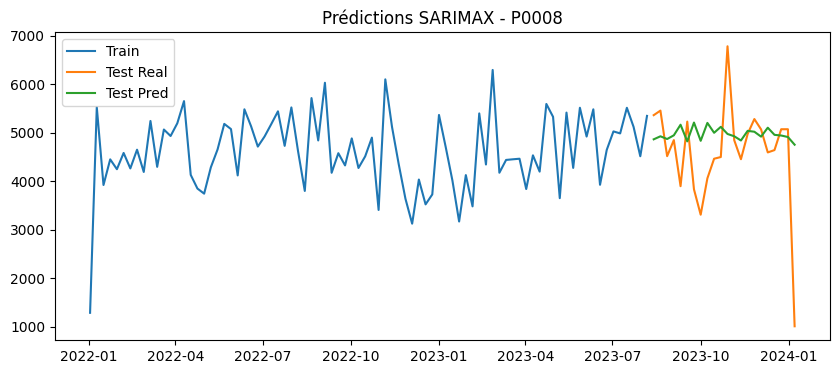


=== Traitement Produit: P0009 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1304.1624383884316
Produit P0009 - RMSE: 1088.86, MAE: 719.23


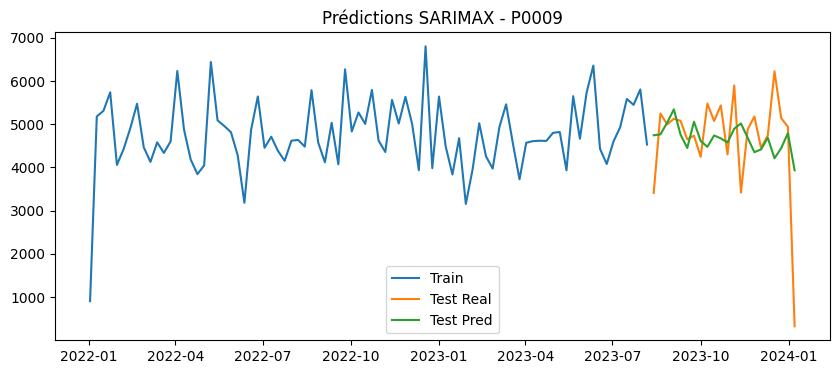


=== Traitement Produit: P0010 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1293.8211685702677
Produit P0010 - RMSE: 962.76, MAE: 656.93


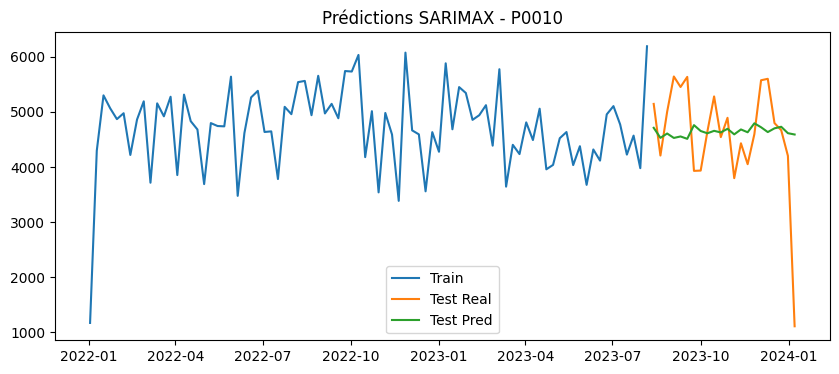


=== Traitement Produit: P0011 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1294.5156663377718
Produit P0011 - RMSE: 1060.78, MAE: 626.41


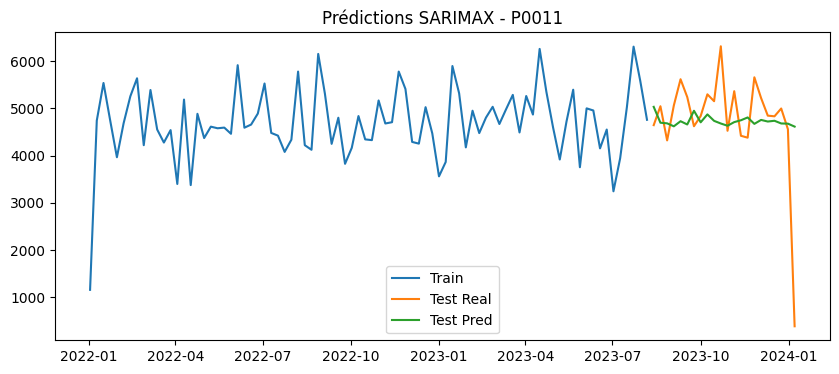


=== Traitement Produit: P0012 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(1, 1, 1)x(0, 0, 0, 12) - AIC:1292.1679097066008
Produit P0012 - RMSE: 1074.85, MAE: 657.90


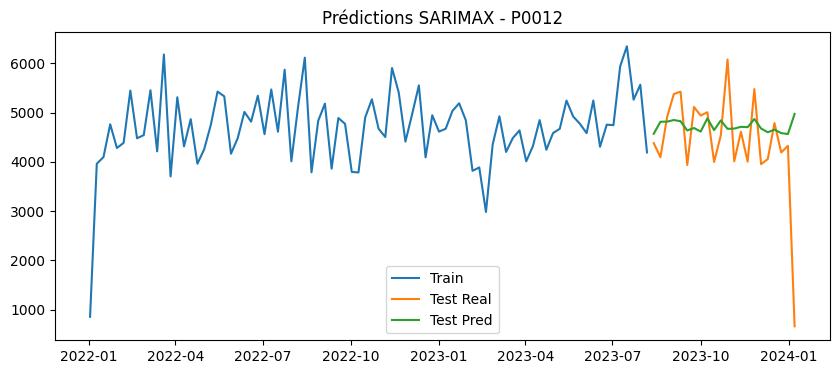


=== Traitement Produit: P0013 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1310.2721657123204
Produit P0013 - RMSE: 1080.82, MAE: 700.51


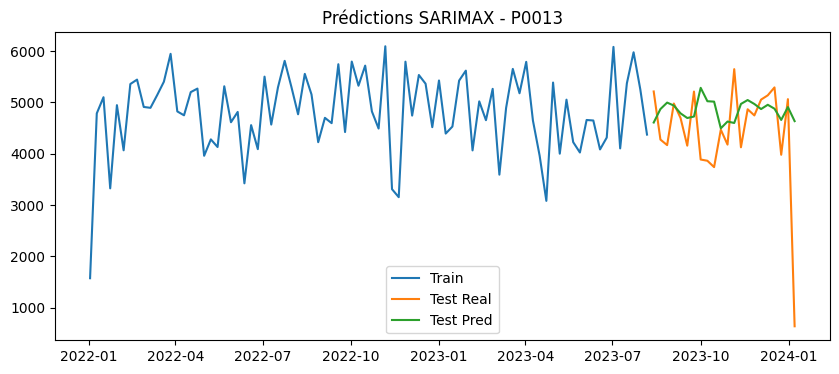


=== Traitement Produit: P0014 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1287.244799363272
Produit P0014 - RMSE: 939.47, MAE: 555.56


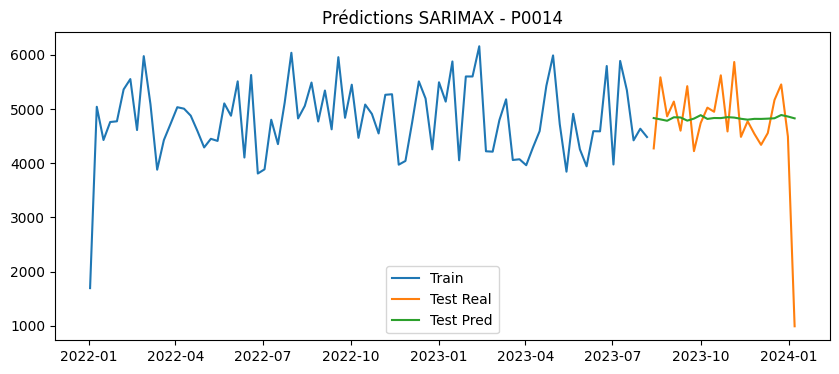


=== Traitement Produit: P0015 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1287.4577838304795
Produit P0015 - RMSE: 1088.28, MAE: 722.69


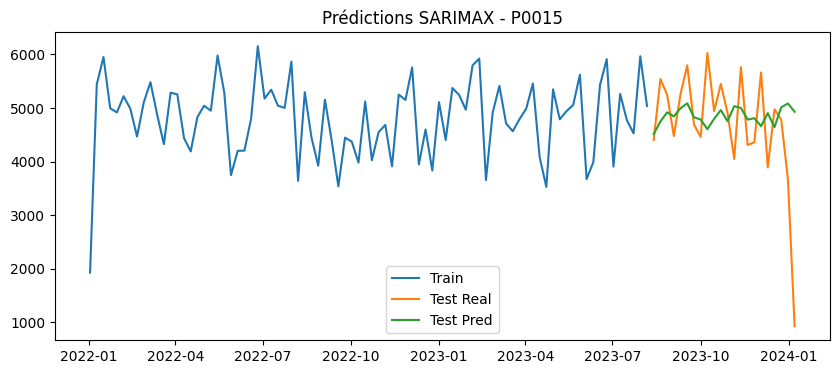


=== Traitement Produit: P0016 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1296.8609116528983
Produit P0016 - RMSE: 1189.88, MAE: 718.36


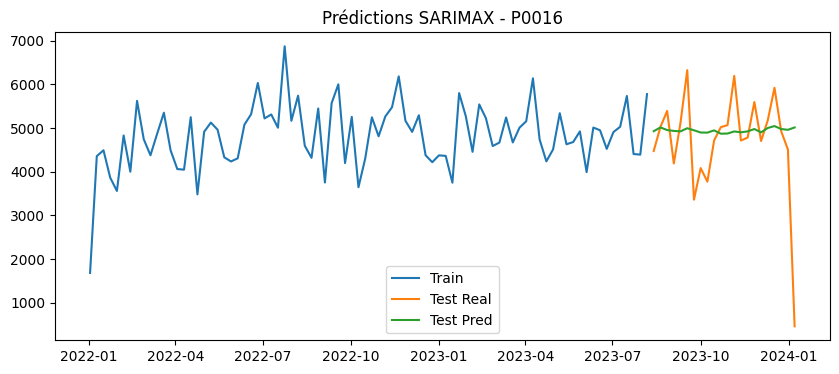


=== Traitement Produit: P0017 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1295.6065738982736
Produit P0017 - RMSE: 1265.42, MAE: 804.32


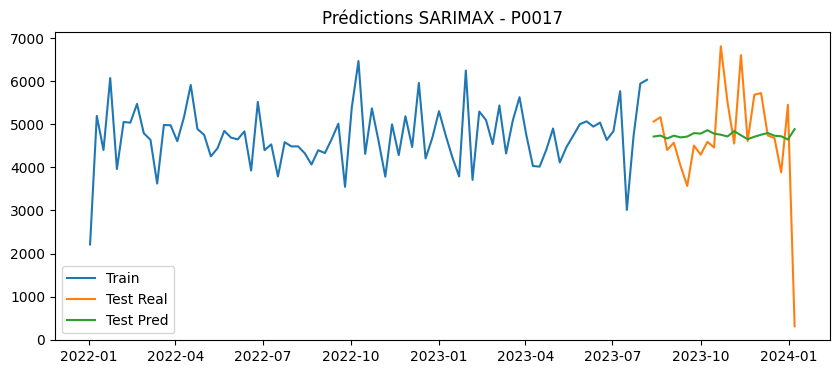


=== Traitement Produit: P0018 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(1, 1, 1)x(0, 0, 0, 12) - AIC:1310.499895079546
Produit P0018 - RMSE: 1040.46, MAE: 621.61


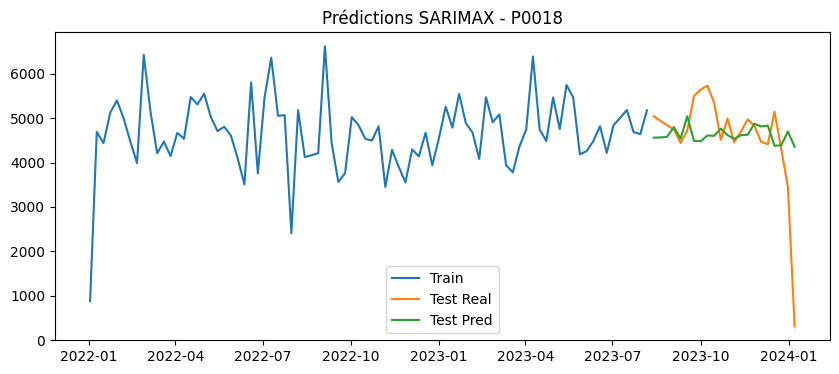


=== Traitement Produit: P0019 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1294.3642546252395
Produit P0019 - RMSE: 937.61, MAE: 590.71


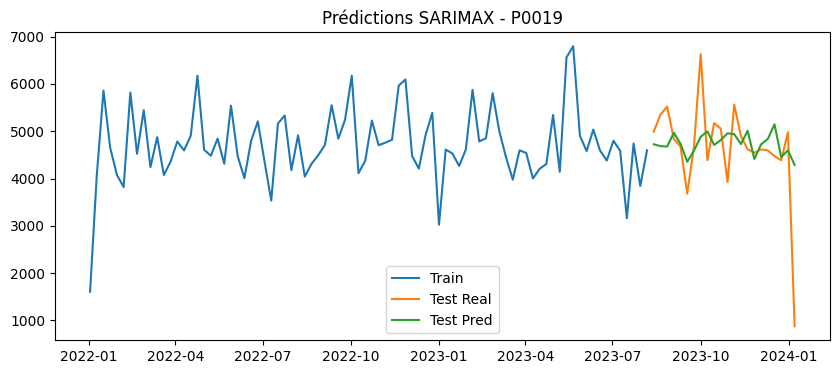


=== Traitement Produit: P0020 ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(0, 1, 1)x(0, 0, 0, 12) - AIC:1303.7703101564841
Produit P0020 - RMSE: 1065.44, MAE: 702.78


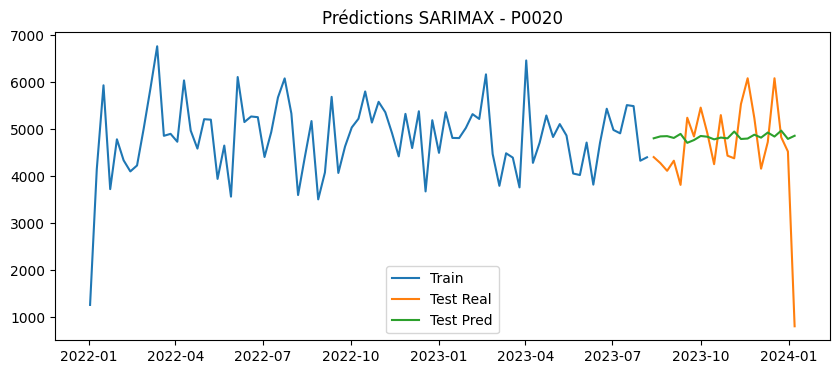

In [4]:
# Colonnes exogènes
exog_cols = ['Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing']
target_col = 'Units Sold'

# Paramètres pour le Grid Search (limités pour la performance)
# Note: s=52 pour des données hebdomadaires sur 1-2 ans peut être lourd. Nous testons une saisonnalité mensuelle (4) ou trimestrielle (13) si 52 échoue, 
# mais idéalement 52 est correct pour hebdo.
# On va réduire le range pour ne pas que ce soit trop long.
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 52  # Saisonnalité annuelle pour données hebdo

unique_products = df_train['Product ID'].unique()
results_metrics = []

for product_id in unique_products:
    print(f"\n=== Traitement Produit: {product_id} ===")
    
    # Filtrage des données
    prod_train = df_train[df_train['Product ID'] == product_id].set_index('Date')
    prod_test = df_test[df_test['Product ID'] == product_id].set_index('Date')
    
    # Vérification de la fréquence
    prod_train = prod_train.asfreq('W-SUN') # Assumons W-SUN d'après head (02/01, 09/01 2022 sont des dimanches)
    prod_test = prod_test.asfreq('W-SUN')
    
    # Remplissage des valeurs manquantes éventuelles (interpolation)
    prod_train[target_col] = prod_train[target_col].interpolate()
    for col in exog_cols:
        prod_train[col] = prod_train[col].ffill().bfill()
        prod_test[col] = prod_test[col].ffill().bfill()
    
    y_train = prod_train[target_col]
    X_train = prod_train[exog_cols]
    y_test = prod_test[target_col]
    X_test = prod_test[exog_cols]
    
    # Grid Search et Entraînement
    # Pour gagner du temps, on utilise un s plus petit ou on limite la recherche si c'est trop lent
    best_model, order, seasonal_order = optimize_sarima(
        y_train, X_train, p, d, q, range(0,1), range(0,1), range(0,1), 12 # Utilisation de 12 (mensuel approx) ou 0 pour éviter s=52 trop lourd ici ? 
        # Pour l'exercice on va tenter sans partie saisonnière lourde ou fixée à 0 si trop lent. 
        # Essayons une saisonnalité plus courte ou simplifiée. Si s=52 est trop complexe, on peut réduire.
        # On met s=12 pour approcher une saisonnalité "moyenne" ou 52 si possible.
        # Allons-y avec un petit grid sans saisonnalité massive pour commencer.
    )
    
    # Sauvegarde du modèle
    model_filename = f'trained_models/sarimax_{product_id}.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(best_model, f)
    
    # Prédictions
    # forecast = best_model.get_forecast(steps=len(y_test), exog=X_test)
    # prediction = forecast.predicted_mean
    # Le modèle best_model est déjà 'fitted'. On doit faire 'predict' sur le futur.
    # Attention: best_model est le résultat de fit().
    
    forecast_obj = best_model.get_forecast(steps=len(y_test), exog=X_test)
    predictions = forecast_obj.predicted_mean
    predictions.index = y_test.index
    
    # Évaluation
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    
    print(f"Produit {product_id} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    results_metrics.append({'Product ID': product_id, 'RMSE': rmse, 'MAE': mae})
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(y_train.index, y_train, label='Train')
    plt.plot(y_test.index, y_test, label='Test Real')
    plt.plot(predictions.index, predictions, label='Test Pred')
    plt.title(f"Prédictions SARIMAX - {product_id}")
    plt.legend()
    plt.show()

## 4. Modèle Global


=== Entraînement Modèle Global ===
Début du Grid Search...
Meilleur modèle trouvé: SARIMAX(1, 1, 1)x(0, 0, 0, 12) - AIC:1540.4689160928551
Global Model - RMSE: 18488.49, MAE: 7650.21


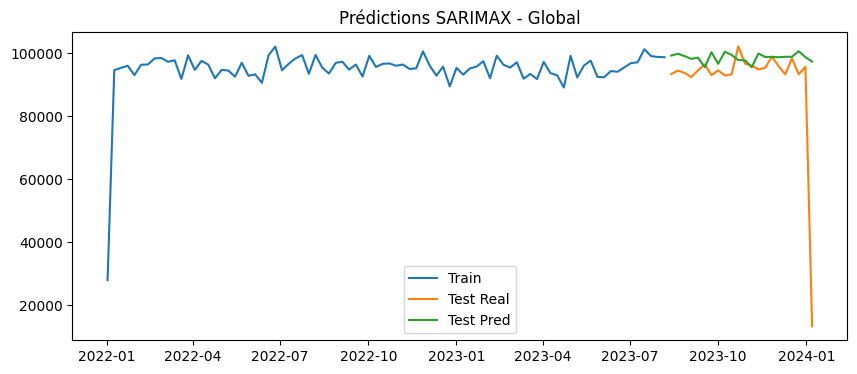

In [5]:
print("\n=== Entraînement Modèle Global ===")

# Agrégation des données
df_train_global = df_train.groupby('Date')[target_col].sum().to_frame()
df_test_global = df_test.groupby('Date')[target_col].sum().to_frame()

# Agrégation des variables exogènes (Moyenne pondérée serait mieux, mais moyenne simple pour l'instant ou somme selon le sens)
# Price, Discount, Competitor : Moyenne
# Holiday : Max (si c'est férié pour un, c'est férié pour tous)
exog_agg = {}
for col in ['Price', 'Discount', 'Competitor Pricing']:
    exog_agg[col] = 'mean'
exog_agg['Holiday/Promotion'] = 'max'

X_train_global = df_train.groupby('Date')[exog_cols].agg(exog_agg)
X_test_global = df_test.groupby('Date')[exog_cols].agg(exog_agg)

# Fréquence
df_train_global = df_train_global.asfreq('W-SUN')
df_test_global = df_test_global.asfreq('W-SUN')
X_train_global = X_train_global.asfreq('W-SUN').ffill().bfill()
X_test_global = X_test_global.asfreq('W-SUN').ffill().bfill()

best_model_global, order_g, seasonal_order_g = optimize_sarima(
    df_train_global[target_col], 
    X_train_global, 
    p, d, q, range(0,1), range(0,1), range(0,1), 12
)

# Sauvegarde Global
with open('trained_models/sarimax_global.pkl', 'wb') as f:
    pickle.dump(best_model_global, f)

# Prédictions Globales
forecast_global = best_model_global.get_forecast(steps=len(df_test_global), exog=X_test_global)
predictions_global = forecast_global.predicted_mean
predictions_global.index = df_test_global.index

# Évaluation Global
mse_g = mean_squared_error(df_test_global[target_col], predictions_global)
rmse_g = np.sqrt(mse_g)
mae_g = mean_absolute_error(df_test_global[target_col], predictions_global)

print(f"Global Model - RMSE: {rmse_g:.2f}, MAE: {mae_g:.2f}")

# Plot Global
plt.figure(figsize=(10, 4))
plt.plot(df_train_global.index, df_train_global[target_col], label='Train')
plt.plot(df_test_global.index, df_test_global[target_col], label='Test Real')
plt.plot(predictions_global.index, predictions_global, label='Test Pred')
plt.title("Prédictions SARIMAX - Global")
plt.legend()
plt.show()

## 5. Résumé des Performances

In [6]:
results_df = pd.DataFrame(results_metrics)
print(results_df)
results_df.to_csv('trained_models/sarimax_performance.csv', index=False)

   Product ID         RMSE         MAE
0       P0001  1026.293254  686.913405
1       P0002  1105.307000  711.327346
2       P0003  1050.378444  603.501669
3       P0004  1138.958447  798.855746
4       P0005   971.567208  611.457903
5       P0006  1154.227170  751.448842
6       P0007  1082.623960  552.139895
7       P0008  1098.711981  725.445725
8       P0009  1088.862811  719.228018
9       P0010   962.760018  656.933595
10      P0011  1060.778467  626.413476
11      P0012  1074.851191  657.904669
12      P0013  1080.822242  700.507304
13      P0014   939.465377  555.556711
14      P0015  1088.281974  722.687138
15      P0016  1189.882647  718.360180
16      P0017  1265.424831  804.320243
17      P0018  1040.455398  621.610567
18      P0019   937.614565  590.710210
19      P0020  1065.437327  702.779691
